# Counter Fitted Vector Eploration

In [34]:
import random

from tqdm import tqdm, trange

import sklearn

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import graphviz
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from random import shuffle

import gensim

from gensim.models import KeyedVectors

import nltk

from nltk.corpus import wordnet as wn

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/olivier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
#load the vectors
f = open("counter-fitted-vectors.txt", 'r')
L = f.readlines()
f.close()

L = np.array(list(map(lambda s: s.split(), L)))

In [11]:
vectors = np.array(L[:, 1:], dtype=float)

In [16]:
words = L[:, 0]

In [18]:
#load the synonym base
f = open("ppdb_synonyms.txt", 'r')
L = f.readlines()
f.close()

In [22]:
synonyms = np.array(list(map(lambda s: s.split(), L)))

In [24]:
#load the antonyms base
f = open("ppdb_antonyms.txt", 'r')
L = f.readlines()
f.close()

In [25]:
antonyms = np.array(list(map(lambda s: s.split(), L)))

In [26]:
#try to make a classifier for synonymy
NB_SAMPLES = 1000

In [31]:
def word2ebd(w):
    return vectors[list(words).index(w)]

def words_ebd_diff(w1, w2):
    return word2ebd(w1) - word2ebd(w2)

In [33]:
positives = []
for i in trange(NB_SAMPLES):
    try:
        positives.append(words_ebd_diff(*random.choice(synonyms)))
    except:
        pass

In [36]:
negatives = []
for i in trange(NB_SAMPLES):
    try:
        negatives.append(words_ebd_diff(*random.choice(antonyms)))
    except:
        pass

100%|██████████| 1000/1000 [01:30<00:00, 11.44it/s]


In [38]:
positives = positives[:min(len(positives), len(negatives))]
negatives = negatives[:len(positives)]

In [39]:
train_pos = positives[:int(len(positives) * .8)]
train_neg = negatives[:int(len(negatives) * .8)]

test_pos = positives[int(len(positives) * .8):]
test_neg = negatives[int(len(negatives) * .8):]

In [45]:
clf = LogisticRegression()
clf.fit(train_pos + train_neg, [1] * len(train_pos) + [0] * len(train_neg))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
preds = clf.predict(test_pos + test_neg)

In [52]:
print(
    "accuracy ",
    (np.array(preds) == np.array([1] * len(test_pos) + [0] * len(test_neg))).mean()
)

accuracy  0.651595744680851


In [57]:
coefs = clf.coef_[0]

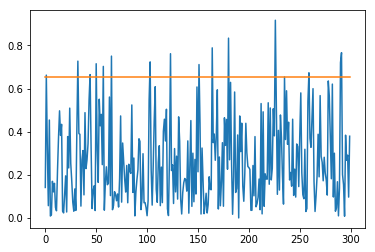

In [66]:
plt.plot(abs(coefs))
plt.plot([(abs(coefs).mean() + 2 * abs(coefs).std())] * len(coefs))
plt.show()

In [67]:
most_important_dims = np.where(abs(coefs) >= (abs(coefs).mean() + 2 * abs(coefs).std()))[0]

In [68]:
clf_few_dim = LogisticRegression()
clf_few_dim.fit(
    list(np.array(train_pos)[:, most_important_dims]) + list(np.array(train_neg)[:, most_important_dims]), 
    [1] * len(train_pos) + [0] * len(train_neg)
)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [76]:
preds_few_dim = clf_few_dim.predict(
    list(np.array(test_pos)[:, most_important_dims]) + list(np.array(test_neg)[:, most_important_dims])
)

In [77]:
print(
    "accuracy few dim",
    (np.array(preds_few_dim) == np.array([1] * len(test_pos) + [0] * len(test_neg))).mean()
)

accuracy few dim 0.5664893617021277


In [78]:
#compare with a non linear classifier...
clf_dt = DecisionTreeClassifier()
clf_dt.fit(
    list(np.array(train_pos)[:, most_important_dims]) + list(np.array(train_neg)[:, most_important_dims]), 
    [1] * len(train_pos) + [0] * len(train_neg)
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [79]:
preds_dt = clf_dt.predict(
    list(np.array(test_pos)[:, most_important_dims]) + list(np.array(test_neg)[:, most_important_dims])
)

In [80]:
print(
    "accuracy decision tree",
    (np.array(preds_dt) == np.array([1] * len(test_pos) + [0] * len(test_neg))).mean()
)

accuracy decision tree 0.949468085106383


In [82]:
clf_dt_all_dims = DecisionTreeClassifier()
clf_dt_all_dims.fit(train_pos + train_neg, [1] * len(train_pos) + [0] * len(train_neg))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
preds_dt_all_dims = clf_dt_all_dims.predict(
    test_pos + test_neg
)

In [84]:
print(
    "accuracy decision tree all dims",
    (np.array(preds_dt_all_dims) == np.array([1] * len(test_pos) + [0] * len(test_neg))).mean()
)

accuracy decision tree all dims 0.949468085106383
